In [192]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import math
keras = tf.keras


In [193]:
test = tf.data.Dataset.from_tensor_slices([1, 2, 3])

In [194]:


import sys
sys.path.append("..")

from mechanism.mechanized_sequential import MechanizedSequential
from mechanism.mechanized_sequential import Mechanism



In [195]:
Q_MEAN = 0.5
EPOCH = 1
POPULATION_SIZE = 500000
TRAIN_DIM = 100
STEP = 10
BATCH_NUM = 1
WINDOW_SIZE = 30

In [196]:

import numpy as np

def initialize_with_str_seed(init_str):
    """
    Initializes random number generator with seed corresponding to given input string init_str.
    :param init_str: Initialization string according to which seed will be computed. Seed is the sum of the ASCII
                     values of each character in init_str.
    """
    rnd_val = 0
    if init_str:
        for c in init_str:
            rnd_val += ord(c)
    np.random.seed(rnd_val)

def gen_data(n, d, seed = None):
    if seed:
        initialize_with_str_seed(seed)
    p = (1.0 + np.sqrt(max(2 * Q_MEAN - 1, 1 - 2 * Q_MEAN))) / 2 
    data = np.random.choice([-1, 1], (n, d), p=[1 -p, p])
    data_y = np.random.choice([0, 1], n, p=[1 -p, p])
    return data, data_y

def gen_valid(n, d, seed = None):
    if seed:
        initialize_with_str_seed(seed)
    
    n = int(n/10)
    
    p = (1.0 + np.sqrt(max(2 * Q_MEAN - 1, 1 - 2 * Q_MEAN))) / 2 
    data = np.random.choice([-1, 1], (n, d), p=[1 -p, p])
    data_y = np.random.choice([0, 1], n, p=[1 -p, p])
    return data, data_y



In [173]:
import math

x_train, y_train = gen_data(POPULATION_SIZE, TRAIN_DIM)
x_valid, y_valid = gen_data(int(POPULATION_SIZE/500), TRAIN_DIM)


In [174]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

In [218]:

def compile_and_fit_model(model, train_set, epoch_num = EPOCH, eager = False):

    
    lr_schedule = keras.callbacks.LearningRateScheduler(
        lambda epoch: 1e-8 * 10**(epoch / 20))
    optimizer = keras.optimizers.SGD(learning_rate=1e-8, momentum=0.9)
    model.compile(loss=keras.losses.Huber(),
                optimizer=optimizer,
                metrics=["mae"],
                run_eagerly = eager)

    history = model.fit(train_set, epochs = epoch_num, callbacks=[lr_schedule])
    return history

def eval_model(train_size, epoch_num = EPOCH, mechanism = Mechanism(Mechanism.MechanismType.NONE)):
    batch_size = math.floor(train_size/STEP)
    # batch_size = 1
    train_set = tf.data.Dataset.from_tensor_slices((x_train[:train_size], y_train[:train_size])).batch(batch_size)

    ''' Compile and fit the empirical model as baseline'''
    # model = MechanizedSequential([
    #     keras.layers.Conv1D(filters = 32,
    #                         kernel_size = 5,
    #                         strides = 1, 
    #                         padding = "causal",
    #                         activation = "relu",
    #                         input_shape = [None, 1]),
    #     # keras.layers.LSTM(32, return_sequences = True,),
    #     # keras.layers.LSTM(32, return_sequences=True),
    #     keras.layers.Dense(1),
    #     keras.layers.Lambda(lambda x: x * 200)
    # ]) 
    #   
    
    
    model = MechanizedSequential([
        keras.layers.LSTM(100, return_sequences=True, stateful=True, batch_input_shape=[batch_size, None, 1]),
        keras.layers.LSTM(100, return_sequences=True, stateful=True),
        keras.layers.Dense(1),
        keras.layers.Lambda(lambda x: x * 200.0)
        ]) 
    
    model = MechanizedSequential([
        keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                            input_shape=[None]),
        keras.layers.SimpleRNN(100, return_sequences=True),
        keras.layers.SimpleRNN(100),
        keras.layers.Dense(1),
        keras.layers.Lambda(lambda x: x * 200.0)
        ])
    
    model = MechanizedSequential([
        keras.layers.Dense(1, input_shape = [batch_size])
        ])
    model = MechanizedSequential([
        keras.layers.Dense(1, input_shape = [batch_size]),
        keras.layers.Lambda(lambda x: x * 200.0),
        keras.layers.Dense(1)
        ])
    model = MechanizedSequential([
        keras.layers.Conv1D(filters = 32,
                            kernel_size = 5,
                            strides = 1, 
                            padding = "causal",
                            activation = "relu",
                            input_shape = [None, 1]),
        keras.layers.LSTM(32, return_sequences = True,),
        keras.layers.LSTM(32, return_sequences=True),
        keras.layers.Dense(1),
        keras.layers.Lambda(lambda x: x * 200)
    ])   

    if not (mechanism.mechanism_type == Mechanism.MechanismType.NONE):
        model.choose_mech(mechanism)
        history = compile_and_fit_model(model, train_set, epoch_num, True)
    else:
        history = compile_and_fit_model(model, train_set, epoch_num, False)


    ''' Validate the result'''
    # x_valid, y_valid = gen_valid(POPULATION_SIZE, TRAIN_DIM)
    # model.choose_mech(None)
    valid_set = tf.data.Dataset.from_tensor_slices(x_valid).batch(batch_size)
    predict = model.predict(valid_set)
    
    error = generalization_error(y_valid, predict)
    return history, predict, error


def generalization_error(true_val, predict_val):
    error = keras.metrics.RootMeanSquaredError()
    error.update_state(true_val, predict_val)
    return error.result().numpy()



def eval_const_rounds(stepped_train_size, epoch_num = EPOCH, mechanism = Mechanism(Mechanism.MechanismType.NONE)):
    history_list, predict_list, generalization_error_list = [], [], []
    for n in stepped_train_size:
        history, predict, error = eval_model(train_size = n, epoch_num = epoch_num, mechanism = mechanism)
        history_list.append(history)
        predict_list.append(predict)
        generalization_error_list.append(error) 

    return history_list, predict_list, generalization_error_list




# Evaluate the Model

In [35]:
max_query_num = 1001
min_query_num = 1000
step = 50
stepped_query_num = range(min_query_num, max_query_num, step)

In [214]:
baseline_history_list, baseline_predict_list, baseline_generalization_error_list = eval_const_rounds(stepped_query_num)
print(baseline_generalization_error_list)

10/10 [==============================] - 0s 1ms/step
[4.593224]


In [224]:
''' eval the empirical model as baseline'''
baseline_generalization_error_list = [eval_const_rounds(stepped_query_num)[2] for _ in range(10)]
print(np.mean(baseline_generalization_error_list, axis = 0))

10/10 [==============================] - 1s 21ms/step
[10.55839]


In [ ]:
_, _, gaussian_generalization_error_list = eval_const_rounds(stepped_query_num, mechanism = Mechanism(Mechanism.MechanismType.GAUSSIAN, sigma = 0.03))
print((gaussian_generalization_error_list))
print(np.mean(gaussian_generalization_error_list))

In [222]:

gaussian_generalization_error_list = [eval_const_rounds(stepped_query_num, mechanism = Mechanism(Mechanism.MechanismType.GAUSSIAN, sigma = 0.03))[2] for _ in range(20)]
print(np.mean(gaussian_generalization_error_list, axis = 0))

In Gaussian Mechanism
Create Gaussian noise when accessing the training data
 1/10 [==>...........................] - ETA: 5s - loss: 4.2712 - mae: 4.7542In Gaussian Mechanism
Create Gaussian noise when accessing the training data
 2/10 [=====>........................] - ETA: 4s - loss: 4.2831 - mae: 4.7659In Gaussian Mechanism
Create Gaussian noise when accessing the training data
 3/10 [========>.....................] - ETA: 3s - loss: 4.2746 - mae: 4.7573In Gaussian Mechanism
Create Gaussian noise when accessing the training data
 4/10 [===========>..................] - ETA: 3s - loss: 4.2862 - mae: 4.7691In Gaussian Mechanism
Create Gaussian noise when accessing the training data
 5/10 [==============>...............] - ETA: 2s - loss: 4.3138 - mae: 4.7970In Gaussian Mechanism
Create Gaussian noise when accessing the training data
 6/10 [=================>............] - ETA: 2s - loss: 4.3212 - mae: 4.8043In Gaussian Mechanism
Create Gaussian noise when accessing the training data

In [221]:
threshold_generalization_error_list = [eval_const_rounds(stepped_query_num, mechanism = Mechanism(Mechanism.MechanismType.THRESHOLD, sigma = 0.03, hold_frac = 0.5, threshold = 0.5))[2] for _ in range(10)]
print(np.mean(threshold_generalization_error_list, axis = 0))

In Threshold out Mechanism
10/10 [==============================] - 2s 202ms/step
In Threshold out Mechanism
10/10 [==============================] - 2s 197ms/step
In Threshold out Mechanism
10/10 [==============================] - 2s 197ms/step
In Threshold out Mechanism
10/10 [==============================] - 2s 201ms/step
In Threshold out Mechanism
10/10 [==============================] - 2s 195ms/step
In Threshold out Mechanism
10/10 [==============================] - 2s 195ms/step
In Threshold out Mechanism
10/10 [==============================] - 2s 198ms/step
In Threshold out Mechanism
10/10 [==============================] - 2s 194ms/step
In Threshold out Mechanism
10/10 [==============================] - 2s 198ms/step
In Threshold out Mechanism
10/10 [==============================] - 2s 196ms/step
[6.6821547]


In [170]:

''' Compile and fit the threshold out model'''
threshold_history_list, threshold_predict_list, threshold_generalization_error_list = eval_const_rounds(stepped_train_size = stepped_query_num, mechanism = Mechanism(Mechanism.MechanismType.THRESHOLD, sigma = 0.1, hold_frac = 0.7, threshold = 0.5))
print(threshold_generalization_error_list)
print(np.mean(threshold_generalization_error_list))


Epoch 1/2
In Threshold out Mechanism
<dtype: 'int64'>
 1/10 [==>...........................] - ETA: 17s - loss: 1.0291 - mae: 1.4662In Threshold out Mechanism
<dtype: 'int64'>
 2/10 [=====>........................] - ETA: 12s - loss: 1.0327 - mae: 1.4850In Threshold out Mechanism
<dtype: 'int64'>
 3/10 [========>.....................] - ETA: 11s - loss: 1.0376 - mae: 1.4827In Threshold out Mechanism
<dtype: 'int64'>
 4/10 [===========>..................] - ETA: 9s - loss: 1.0387 - mae: 1.4841 In Threshold out Mechanism
<dtype: 'int64'>
 5/10 [==============>...............] - ETA: 7s - loss: 1.0391 - mae: 1.4802In Threshold out Mechanism
<dtype: 'int64'>
 6/10 [=================>............] - ETA: 6s - loss: 1.0424 - mae: 1.4790In Threshold out Mechanism
<dtype: 'int64'>
 7/10 [====================>.........] - ETA: 4s - loss: 1.0439 - mae: 1.4823In Threshold out Mechanism
<dtype: 'int64'>
 8/10 [=======================>......] - ETA: 3s - loss: 1.0490 - mae: 1.4880In Threshold out M

In [ ]:
data_split_error_list = eval_const_rounds(stepped_query_num, mechanism = Mechanism(Mechanism.MechanismType.DATASPLIT, sigma = 0.03))


In [220]:
data_split_error_list = [eval_const_rounds(stepped_query_num, mechanism = Mechanism(Mechanism.MechanismType.DATASPLIT))[2] for _ in range(10)]
print(np.mean(data_split_error_list, axis = 0))

In Naive Data Splitting Mechanism
In Naive Data Split
 1/10 [==>...........................] - ETA: 5s - loss: 24.5999 - mae: 25.0977In Naive Data Splitting Mechanism
In Naive Data Split
 2/10 [=====>........................] - ETA: 4s - loss: 24.5174 - mae: 25.0150In Naive Data Splitting Mechanism
In Naive Data Split
 3/10 [========>.....................] - ETA: 3s - loss: 24.6370 - mae: 25.1348In Naive Data Splitting Mechanism
In Naive Data Split
 4/10 [===========>..................] - ETA: 3s - loss: 24.6566 - mae: 25.1544In Naive Data Splitting Mechanism
In Naive Data Split
 5/10 [==============>...............] - ETA: 2s - loss: 24.6740 - mae: 25.1720In Naive Data Splitting Mechanism
In Naive Data Split
 6/10 [=================>............] - ETA: 2s - loss: 24.6474 - mae: 25.1454In Naive Data Splitting Mechanism
In Naive Data Split
 7/10 [====================>.........] - ETA: 1s - loss: 24.6032 - mae: 25.1011In Naive Data Splitting Mechanism
In Naive Data Split
 8/10 [========

In [219]:
baseline_generalization_error_list = [eval_const_rounds(stepped_query_num)[2] for _ in range(10)]
print(np.mean(baseline_generalization_error_list, axis = 0))

data_split_error_list = [eval_const_rounds(stepped_query_num, mechanism = Mechanism(Mechanism.MechanismType.DATASPLIT, sigma = 0.03))[2] for _ in range(10)]
print(np.mean(data_split_error_list, axis = 0))
threshold_generalization_error_list = [eval_const_rounds(stepped_query_num, mechanism = Mechanism(Mechanism.MechanismType.THRESHOLD, sigma = 0.03, hold_frac = 0.5, threshold = 0.5))[2] for _ in range(10)]
print(np.mean(threshold_generalization_error_list, axis = 0))
gaussian_generalization_error_list = [eval_const_rounds(stepped_query_num, mechanism = Mechanism(Mechanism.MechanismType.GAUSSIAN, sigma = 0.03))[2] for _ in range(10)]
print(np.mean(gaussian_generalization_error_list, axis = 0))


print(np.mean(baseline_generalization_error_list, axis = 0), np.mean(data_split_error_list, axis = 0), np.mean(gaussian_generalization_error_list, axis = 0), np.mean(threshold_generalization_error_list, axis = 0) )


In Naive Data Splitting Mechanism
In Naive Data Split
 1/10 [==>...........................] - ETA: 5s - loss: 5.5064 - mae: 5.9909In Naive Data Splitting Mechanism
In Naive Data Split
 2/10 [=====>........................] - ETA: 5s - loss: 5.4677 - mae: 5.9516In Naive Data Splitting Mechanism
In Naive Data Split
 3/10 [========>.....................] - ETA: 4s - loss: 5.5438 - mae: 6.0281In Naive Data Splitting Mechanism
In Naive Data Split
 4/10 [===========>..................] - ETA: 3s - loss: 5.5810 - mae: 6.0654In Naive Data Splitting Mechanism
In Naive Data Split
 5/10 [==============>...............] - ETA: 2s - loss: 5.5905 - mae: 6.0748In Naive Data Splitting Mechanism
In Naive Data Split
 6/10 [=================>............] - ETA: 2s - loss: 5.5796 - mae: 6.0640In Naive Data Splitting Mechanism
In Naive Data Split
 7/10 [====================>.........] - ETA: 1s - loss: 5.5493 - mae: 6.0337In Naive Data Splitting Mechanism
In Naive Data Split
 8/10 [======================

In [225]:
print(np.mean(baseline_generalization_error_list, axis = 0), np.mean(data_split_error_list, axis = 0), np.mean(gaussian_generalization_error_list, axis = 0), np.mean(threshold_generalization_error_list, axis = 0) )


[10.55839] [12.198408] [10.579981] [6.6821547]


In [12]:


'''
Plot the Comparison of the Three Model
'''
def plot_error(rounds, generalization_error, mechanism, color = None):
    plt.plot(rounds, generalization_error, color, label = mechanism)
    plt.xlabel("Queries")
    plt.ylabel("RMSE (Generalization Error) for adaptive queries")
    plt.legend()
    plt.grid()


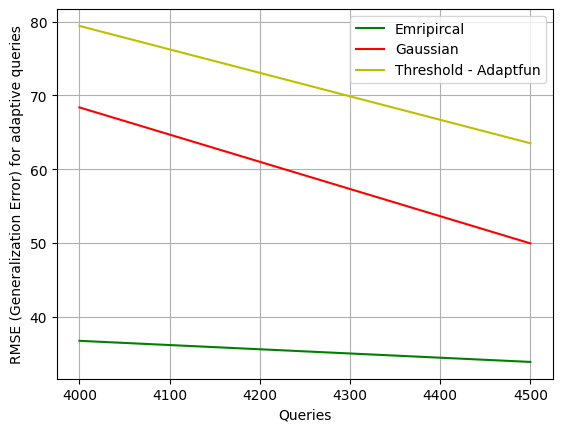

In [19]:

""" plot the generalization error """
plt.figure()
x_range = stepped_query_num
plot_error(x_range, (baseline_generalization_error_list), "Emripircal", 'g')
plot_error(x_range, (gaussian_generalization_error_list), "Gaussian", 'r')
plot_error(x_range, (threshold_generalization_error_list), "Threshold - Adaptfun", "y")
plt.savefig("../plots/n_adaptivity.png")
plt.show()

# Evaluate the O(n) adaptivity

In [26]:

def eval_multiple_rounds(train_size, stepped_epoch_num, mechanism = Mechanism(Mechanism.MechanismType.NONE)):
    history_list, predict_list, generalization_error_list = [], [], []
    for r in stepped_epoch_num:
        history, predict, error = eval_model(train_size = train_size, epoch_num = r, mechanism = mechanism)
        history_list.append(history)
        predict_list.append(predict)
        generalization_error_list.append(error) 

    return history_list, predict_list, generalization_error_list

In [46]:
max_query_num = 500
max_rounds = 100
min_rounds = 10
round_step = 10
stepped_rounds = range(min_rounds, max_rounds, round_step)

In [ ]:
''' eval the empirical model as baseline'''
baseline_history_list, baseline_predict_list, baseline_generalization_error_list = eval_multiple_rounds(max_query_num, stepped_rounds)
print(baseline_generalization_error_list)

In [ ]:
''' Compile and fit the gaussian model'''
gaussian_history_list, gaussian_preditc_list, gaussian_generalization_error_list = eval_multiple_rounds(max_query_num, stepped_rounds, mechanism = Mechanism(Mechanism.MechanismType.GAUSSIAN, sigma = 0.03))

In [49]:
print(gaussian_generalization_error_list)

[inf, inf, nan]


In [50]:

''' Compile and fit the threshold out model'''
threshold_history_list, threshold_predict_list, threshold_generalization_error_list = eval_multiple_rounds(max_query_num, stepped_rounds, mechanism = Mechanism(Mechanism.MechanismType.THRESHOLD, sigma = 0.1, hold_frac = 0.4, threshold = 0.5))
print(threshold_generalization_error_list)

Epoch 1/700
In Threshold out Mechanism
1/1 [==============================] - 0s 374ms/step - loss: 61.7763 - mae: 62.6778 - lr: 1.0000e-08
Epoch 2/700
In Threshold out Mechanism
1/1 [==============================] - 1s 799ms/step - loss: 61.7433 - mae: 62.2056 - lr: 1.1220e-08
Epoch 3/700
In Threshold out Mechanism
1/1 [==============================] - 0s 296ms/step - loss: 61.7737 - mae: 62.6752 - lr: 1.2589e-08
Epoch 4/700
In Threshold out Mechanism
1/1 [==============================] - 1s 808ms/step - loss: 61.7390 - mae: 62.2013 - lr: 1.4125e-08
Epoch 5/700
In Threshold out Mechanism
1/1 [==============================] - 0s 273ms/step - loss: 61.7675 - mae: 62.6691 - lr: 1.5849e-08
Epoch 6/700
In Threshold out Mechanism
1/1 [==============================] - 0s 298ms/step - loss: 61.7630 - mae: 62.6646 - lr: 1.7783e-08
Epoch 7/700
In Threshold out Mechanism
1/1 [==============================] - 0s 325ms/step - loss: 61.7575 - mae: 62.6590 - lr: 1.9953e-08
Epoch 8/700
In Thres

Epoch 1/800
In Threshold out Mechanism
1/1 [==============================] - 1s 830ms/step - loss: 30.8209 - mae: 31.2982 - lr: 1.0000e-08
Epoch 2/800
In Threshold out Mechanism
1/1 [==============================] - 1s 827ms/step - loss: 30.8205 - mae: 31.2977 - lr: 1.1220e-08
Epoch 3/800
In Threshold out Mechanism
1/1 [==============================] - 1s 836ms/step - loss: 30.8195 - mae: 31.2968 - lr: 1.2589e-08
Epoch 4/800
In Threshold out Mechanism
1/1 [==============================] - 1s 853ms/step - loss: 30.8181 - mae: 31.2953 - lr: 1.4125e-08
Epoch 5/800
In Threshold out Mechanism
1/1 [==============================] - 0s 316ms/step - loss: 30.8317 - mae: 31.5228 - lr: 1.5849e-08
Epoch 6/800
In Threshold out Mechanism
1/1 [==============================] - 1s 823ms/step - loss: 30.8136 - mae: 31.2908 - lr: 1.7783e-08
Epoch 7/800
In Threshold out Mechanism
1/1 [==============================] - 1s 834ms/step - loss: 30.8105 - mae: 31.2877 - lr: 1.9953e-08
Epoch 8/800
In Thres

/usr/local/lib/python3.10/site-packages/numpy/core/_methods.py:179: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)


1/1 [==============================] - 1s 881ms/step - loss: inf - mae: inf - lr: 22387212319743359777827788423168.0000
Epoch 789/800
In Threshold out Mechanism
1/1 [==============================] - 1s 780ms/step - loss: inf - mae: inf - lr: 25118864833969987422118622527488.0000
Epoch 790/800
In Threshold out Mechanism
1/1 [==============================] - 1s 849ms/step - loss: inf - mae: inf - lr: 28183830285922564476167696416768.0000
Epoch 791/800
In Threshold out Mechanism
1/1 [==============================] - 1s 825ms/step - loss: inf - mae: inf - lr: 31622776940172927065412125851648.0000
Epoch 792/800
In Threshold out Mechanism


/usr/local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


1/1 [==============================] - 1s 837ms/step - loss: inf - mae: inf - lr: 35481339328559888211938719563776.0000
Epoch 793/800
In Threshold out Mechanism
1/1 [==============================] - 1s 856ms/step - loss: inf - mae: inf - lr: 39810717877395766690554633519104.0000
Epoch 794/800
In Threshold out Mechanism
1/1 [==============================] - 1s 851ms/step - loss: inf - mae: inf - lr: 44668358323777010450383555788800.0000
Epoch 795/800
In Threshold out Mechanism
1/1 [==============================] - 1s 818ms/step - loss: inf - mae: inf - lr: 50118723010257110748279169089536.0000
Epoch 796/800
In Threshold out Mechanism
1/1 [==============================] - 1s 810ms/step - loss: inf - mae: inf - lr: 56234132297217053930730746281984.0000
Epoch 797/800
In Threshold out Mechanism
1/1 [==============================] - 1s 810ms/step - loss: inf - mae: inf - lr: 63095734121372652366461264723968.0000
Epoch 798/800
In Threshold out Mechanism
1/1 [=============================

Epoch 1/900
In Threshold out Mechanism
1/1 [==============================] - 1s 794ms/step - loss: 23.9922 - mae: 24.4594 - lr: 1.0000e-08
Epoch 2/900
In Threshold out Mechanism
1/1 [==============================] - 1s 805ms/step - loss: 23.9919 - mae: 24.4592 - lr: 1.1220e-08
Epoch 3/900
In Threshold out Mechanism
1/1 [==============================] - 0s 301ms/step - loss: 24.0121 - mae: 24.7604 - lr: 1.2589e-08
Epoch 4/900
In Threshold out Mechanism
1/1 [==============================] - 0s 285ms/step - loss: 24.0114 - mae: 24.7597 - lr: 1.4125e-08
Epoch 5/900
In Threshold out Mechanism
1/1 [==============================] - 1s 769ms/step - loss: 23.9899 - mae: 24.4571 - lr: 1.5849e-08
Epoch 6/900
In Threshold out Mechanism
1/1 [==============================] - 0s 302ms/step - loss: 24.0092 - mae: 24.7576 - lr: 1.7783e-08
Epoch 7/900
In Threshold out Mechanism
1/1 [==============================] - 1s 792ms/step - loss: 23.9872 - mae: 24.4544 - lr: 1.9953e-08
Epoch 8/900
In Thres

/var/folders/_j/z7zdrth14_s3bcxmp4glxrw40000gp/T/ipykernel_36974/1855233911.py:225: RuntimeWarning: invalid value encountered in subtract
  diff = (np.sum(y_pred_train.numpy(), axis = 0) / train_size - np.sum(y_pred_hold.numpy(), axis = 0) / hold_size)


1/1 [==============================] - 1s 1s/step - loss: inf - mae: inf - lr: 398107164266847831529996238716928.0000
Epoch 814/900
In Threshold out Mechanism
1/1 [==============================] - 1s 867ms/step - loss: inf - mae: inf - lr: 446683583237770104503835557888000.0000
Epoch 815/900
In Threshold out Mechanism
1/1 [==============================] - 1s 1s/step - loss: inf - mae: inf - lr: 501187220431164550565758293245952.0000
Epoch 816/900
In Threshold out Mechanism
1/1 [==============================] - 1s 1s/step - loss: inf - mae: inf - lr: 562341342314983653141374258118656.0000
Epoch 817/900
In Threshold out Mechanism
1/1 [==============================] - 1s 1s/step - loss: inf - mae: inf - lr: 630957341213726523664612647239680.0000
Epoch 818/900
In Threshold out Mechanism
1/1 [==============================] - 1s 1s/step - loss: inf - mae: inf - lr: 707945799397540014663928947671040.0000
Epoch 819/900
In Threshold out Mechanism
1/1 [==============================] - 1s 9

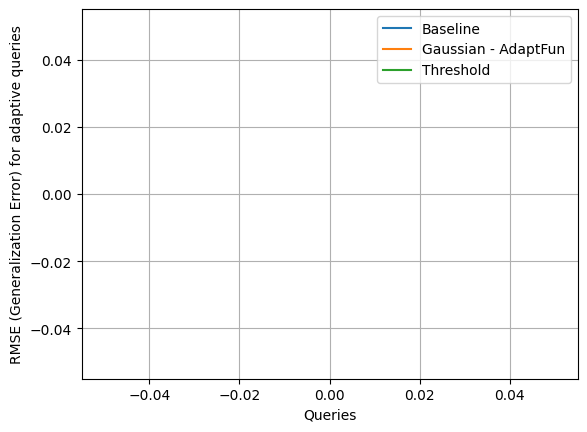

In [52]:

""" plot the generalization error """
plt.figure()
plot_error(stepped_rounds, baseline_generalization_error_list, "Baseline")
plot_error(stepped_rounds, gaussian_generalization_error_list, "Gaussian - AdaptFun")
plot_error(stepped_rounds, threshold_generalization_error_list, "Threshold")
plt.show()

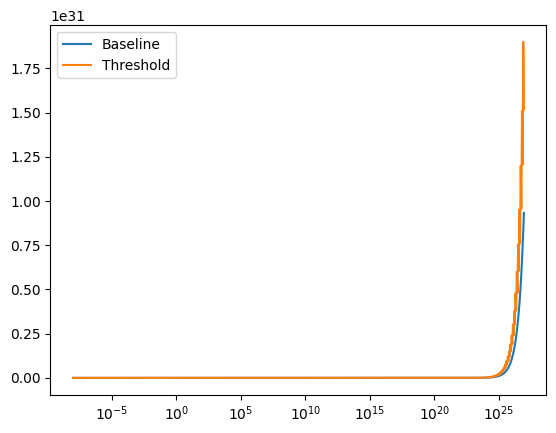

In [56]:
plt.semilogx(baseline_history_list[0].history["lr"], baseline_history_list[0].history["loss"], label = "Baseline")
# plt.semilogx(gaussian_history.history["lr"], gaussian_history.history["loss"], label = "Gaussian")
plt.semilogx(threshold_history_list[0].history["lr"], threshold_history_list[0].history["loss"], label = "Threshold")

plt.legend()